In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sklearn
import pandas
import os
import warnings
import datetime
import sys
import matplotlib

font = {"family": "serif",
        "weight": "normal",
        "size": 15}

matplotlib.rc("font", **font)
matplotlib.rcParams["figure.figsize"] = (8, 6)
matplotlib.rcParams['figure.dpi'] = 75

def makeNiceAxes(ax, xlab=None, ylab=None):
    ax.tick_params(axis='both', reset=False, which='both', length=5, width=2)
    ax.tick_params(axis='y', direction='out', which="both")
    ax.tick_params(axis='x', direction='out', which="both")
    for spine in ['top', 'right','bottom','left']:
        ax.spines[spine].set_linewidth(2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    
def niceFig(xlab=None, ylab=None, figsize=None, nrows=1, ncols=1):
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize)
    if (nrows == 1) and (ncols == 1):
        makeNiceAxes(ax, xlab, ylab)
    else:
        for axx in ax:
            makeNiceAxes(axx, xlab, ylab)
    return fig, ax

def addColourBar(fig, cs, cbarLabel, pos=[0.85, .25, 0.03, 0.5], orientation="vertical"):
    position = fig.add_axes(pos)
    cbar = fig.colorbar(cs, cax=position, orientation=orientation)
    cbar.set_label(cbarLabel)
    return cbar

# Constants

In [2]:
projectDir = "D:/git/JellyfishGiggles"
sys.path.append(projectDir)
import utils

# Motion

In [3]:
# No. segments
kinematics = {
    "Baseline": {
        "Nsegments": 6,
        "theta": np.array([
            [0, 0.025, 0.15, 0.25, 0.35, 0.45, 1.0],
                [0., 0.,        0., 0., 0.,       0., 0.],
                [0., 0.,        0., 0., 0.,       0., 0.],
                [0.39, 0.39,        0., 0.38, 0.39,       0.39, 0.39],
                [0.4, 0.4,        0.85, 1.2, 0.41,       0.4, 0.4],
                [0.95, 0.95,        1.95, 1.65, 0.95,       0.95, 0.95],
                [2.2, 2.2,        -1., 2.19, 2.2,       2.2, 2.2],
        ]),
        "length": np.array([
            [0, 0.025, 0.15, 0.25, 0.35, 0.45, 1.0],
                [0.02, 0.02,        0.01, 0.03, 0.022,       0.02, 0.02],
                [0.04, 0.04,        0.02, 0.06, 0.04,       0.04, 0.04],
                [0.12, 0.12,        0.1, 0.155, 0.11,       0.12, 0.12],
                [0.194, 0.194,        0.275, 0.194, 0.194,       0.194, 0.194],
                [0.228, 0.228,        0.16, 0.225, 0.228,       0.228, 0.228],
                [0.250, 0.250,        0.135, 0.245, 0.250,       0.250, 0.250],
        ]),
        "thick": np.array([
            [0, 0.025, 0.15, 0.25, 0.35, 0.45, 1.0],
                [0.097, 0.097,        0.1005, 0.0875, 0.097,       0.097, 0.097],
                [0.097, 0.097,        0.1005, 0.0875, 0.097,       0.097, 0.097],
                [0.083, 0.083,        0.11, 0.075, 0.083,       0.083, 0.083],
                [0.063, 0.063,        0.075, 0.04, 0.063,       0.063, 0.063],
                [0.0335, 0.0335,        0.045, 0.0345, 0.034,       0.0335, 0.0335],
                [0.011, 0.011,        0.011, 0.011, 0.011,       0.011, 0.011],
        ])
    },
    "No flick": {
        "Nsegments": 6,
        "theta": np.array([
            [0, 0.025, 0.15, 0.25, 0.35, 0.45, 1.0],
                [0., 0.,        0., 0., 0.,       0., 0.],
                [0., 0.,        0., 0., 0.,       0., 0.],
                [0.39, 0.39,        0., 0.38, 0.39,       0.39, 0.39],
                [0.4, 0.4,        0.85, 1.2, 0.41,       0.4, 0.4],
                [0.95, 0.95,        1.95, 1.65, 0.95,       0.95, 0.95],
                [2.2, 2.2,        2., 2., 2.,       2.2, 2.2],  # !!!
        ]),
        "length": np.array([
            [0, 0.025, 0.15, 0.25, 0.35, 0.45, 1.0],
                [0.02, 0.02,        0.01, 0.03, 0.022,       0.02, 0.02],
                [0.04, 0.04,        0.02, 0.06, 0.04,       0.04, 0.04],
                [0.12, 0.12,        0.1, 0.155, 0.11,       0.12, 0.12],
                [0.194, 0.194,        0.275, 0.194, 0.194,       0.194, 0.194],
                [0.228, 0.228,        0.16, 0.225, 0.228,       0.228, 0.228],
                [0.250, 0.250,        0.135, 0.245, 0.250,       0.250, 0.250],
        ]),
        "thick": np.array([
            [0, 0.025, 0.15, 0.25, 0.35, 0.45, 1.0],
                [0.097, 0.097,        0.1005, 0.0875, 0.097,       0.097, 0.097],
                [0.097, 0.097,        0.1005, 0.0875, 0.097,       0.097, 0.097],
                [0.083, 0.083,        0.11, 0.075, 0.083,       0.083, 0.083],
                [0.063, 0.063,        0.075, 0.04, 0.063,       0.063, 0.063],
                [0.0335, 0.0335,        0.045, 0.0345, 0.034,       0.0335, 0.0335],
                [0.011, 0.011,        0.011, 0.011, 0.011,       0.011, 0.011],
        ])
    }
}

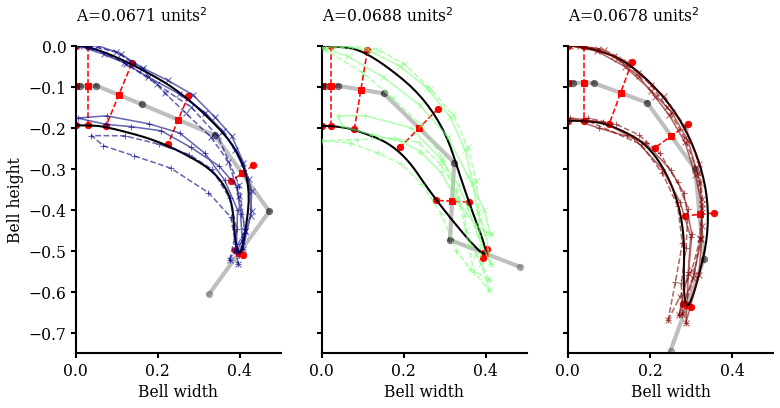

In [27]:
# From Costello 2020 fig 9
# Data contain three snapshots of two cycles. Upper and lower part of the medusa
# (aboral and subumbrellar surfaces) for each.
data_Costello = pandas.read_csv(os.path.join(
    projectDir, "dataset_01_medusae/deformedShapeHistory_Costello2020_fig9.csv"), header=None)
snapshotColoursCostello = plt.cm.jet(np.linspace(0, 1, 3))

fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharex=True, sharey=True)
for ax in axes:
    makeNiceAxes(ax, "Bell width")
    ax.set_aspect("equal")
    ax.set_xlim((0, 0.5))
    ax.set_ylim((-0.75, 0.))
axes[0].set_ylabel("Bell height")

# Plot raw Costello data.
linestyles = ["-", "--"]
for j in range(2):
    for i in range(3):
        i0 = j*4*3+i*4
        # Retrieve the data from the ordered table.
        df = data_Costello[range(i0, i0+4)]
        df.columns = ["xl", "yl", "xu", "yu"]

        # Find the origin of each frame. Assumed at mid-width and top.
        x0 = (df["xu"].max() + df["xu"].min())/2.
        y0 = df["yu"].max()

        # Plot the data for each snapshot.
        axes[i].plot(np.abs(df["xl"]-x0), df["yl"]-y0, linestyles[j]+"+", alpha=0.6, zorder=100, c=snapshotColoursCostello[i])
        axes[i].plot(np.abs(df["xu"]-x0), df["yu"]-y0, linestyles[j]+"x", alpha=0.6, zorder=100, c=snapshotColoursCostello[i])

# Plot regressed shapes.
for i, t in enumerate([0, 0.13, 0.27]):
    kin = "Baseline"
    
    # Get parameters for each control point.
    Lfit, thkFit, thetaFit = [], [], []
    for j in range(kinematics[kin]["Nsegments"]):
        Lfit.append(utils.getSegmentPosition(j, t, kinematics[kin]["length"]))
        thkFit.append(utils.getSegmentPosition(j, t, kinematics[kin]["thick"]))
        thetaFit.append(utils.getSegmentPosition(j, t, kinematics[kin]["theta"]))

    # Compute and plot the profile.
    xy, cps, area = utils.profileFromParams(Lfit, thkFit, thetaFit, ax=axes[i], colour="k")
    
    np.savetxt(os.path.join(projectDir, "dataset_01_medusae/shape_Costello2020_snapshot{:d}.txt".format(i+1)),
        np.hstack([xy, np.zeros((xy.shape[0], 1))]))

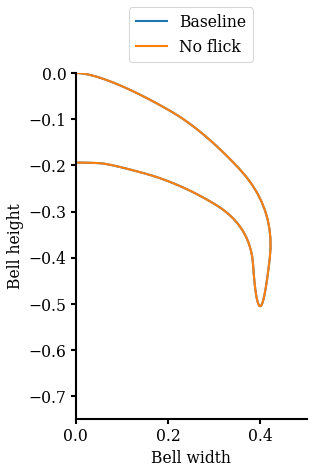

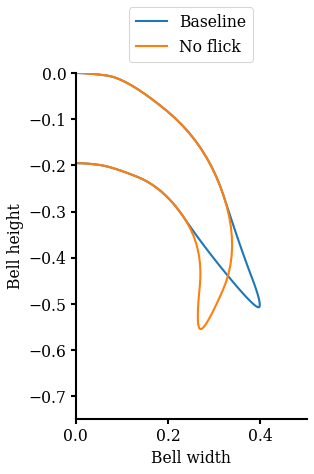

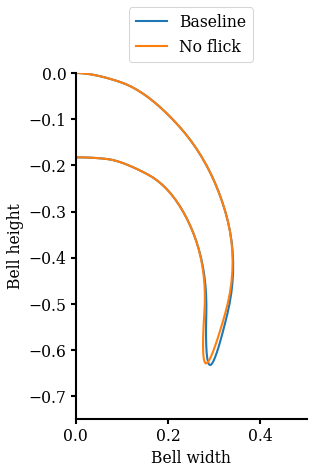

In [29]:
regressedShapes = []
for i in range(3):
    regressedShapes.append(np.loadtxt(
        os.path.join(projectDir, "dataset_01_medusae/shape_Costello2020_snapshot{:d}.txt".format(i+1))))

figs, axes = [], []
for i in range(len(regressedShapes)):
    fig, ax = niceFig("Bell width", "Bell height")
    ax.set_aspect("equal")
    ax.set_xlim((0, 0.5))
    ax.set_ylim((-0.75, 0.))
    # ax.plot(regressedShapes[i][:, 0]-i*0.5, regressedShapes[i][:, 1], "k--", lw=2, label="Costello et al.")
    axes.append(ax)
    figs.append(fig)

for i, t in enumerate([0, 0.13, 0.27]):
    for kin in kinematics:
        # Get parameters for each control point.
        Lfit, thkFit, thetaFit = [], [], []
        for j in range(kinematics[kin]["Nsegments"]):
            Lfit.append(utils.getSegmentPosition(j, t, kinematics[kin]["length"]))
            thkFit.append(utils.getSegmentPosition(j, t, kinematics[kin]["thick"]))
            thetaFit.append(utils.getSegmentPosition(j, t, kinematics[kin]["theta"]))

        # Compute and plot the profile.
        xy, cps, area = utils.profileFromParams(Lfit, thkFit, thetaFit)
        axes[i].plot(xy[:, 0], xy[:, 1], "-", lw=2, label=kin)

for ax in axes:
    ax.legend(loc="lower center", bbox_to_anchor=(0.5, 1.01))

# Validation data from Costello et al.

In [5]:
# %% Read time series data of Costello
ref_Uswim = np.loadtxt(os.path.join(projectDir, "dataset_01_medusae/data_Costello2020_Uswim.txt"))
ref_Uedge = np.loadtxt(os.path.join(projectDir, "dataset_01_medusae/data_Costello2020_Uedge.txt"))
ref_dist = np.loadtxt(os.path.join(projectDir, "dataset_01_medusae/data_Costello2020_totalDistance.txt"))
ref_fin = np.loadtxt(os.path.join(projectDir, "dataset_01_medusae/data_Costello2020_fineness.txt"))

# From the plot by Costello.
tVals = np.array([0.04836558, 0.22848566, 0.41027352, 1.39926618, 1.57771848, 1.76617745])

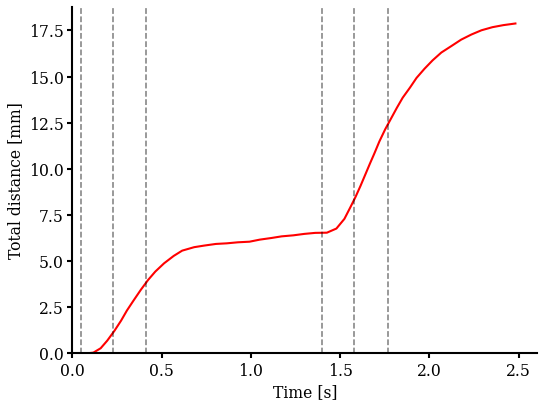

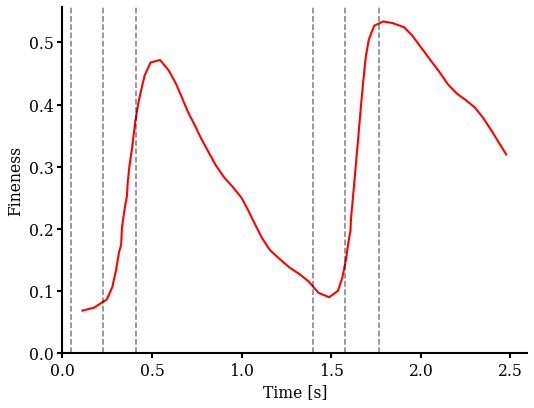

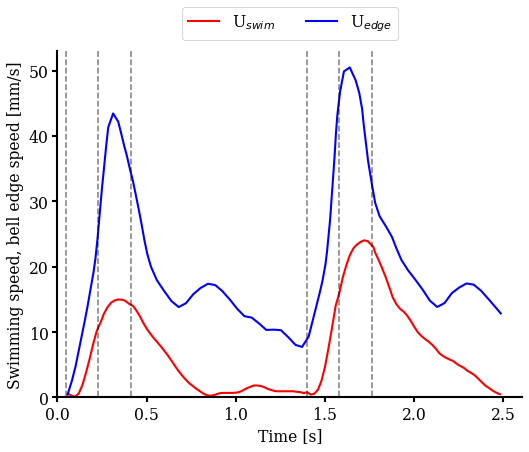

In [6]:
fig, ax = niceFig("Time [s]", "Total distance [mm]")
ax.plot(ref_dist[:, 0], ref_dist[:, 1], "r-", lw=2)
ylim = ax.get_ylim()
ax.set_ylim(0, ylim[1])
ax.set_xlim(0, ax.get_xlim()[1])
ax.vlines(tVals, ylim[0], ylim[1], linestyle="dashed", color="k", alpha=0.5)

fig, ax = niceFig("Time [s]", "Fineness")
ax.plot(ref_fin[:, 0], ref_fin[:, 1], "r-", lw=2)
ylim = ax.get_ylim()
ax.set_ylim(0, ylim[1])
ax.set_xlim(0, ax.get_xlim()[1])
ax.vlines(tVals, 0, ylim[1], linestyle="dashed", color="k", alpha=0.5)

fig, ax = niceFig("Time [s]", "Swimming speed, bell edge speed [mm/s]")
ax.plot(ref_Uswim[:, 0], ref_Uswim[:, 1], "r-", lw=2, label="U$_{swim}$")
ax.plot(ref_Uedge[:, 0], ref_Uedge[:, 1], "b-", lw=2, label="U$_{edge}$")
ax.legend(ncol=2, bbox_to_anchor=(0.5, 1.01), loc="lower center")
ylim = ax.get_ylim()
ax.set_ylim(0, ylim[1])
ax.set_xlim(0, ax.get_xlim()[1])
ax.vlines(tVals, ylim[0], ylim[1], linestyle="dashed", color="k", alpha=0.5)

# Compute the period in second, non-dimensionalise snapshot times to range (0, 1).
period = tVals[3] - tVals[0]
tVals /= period
tVals -= tVals[0]